# Iris Species Prediction

### Imports

In [1]:
import matplotlib as plt

import seaborn as sns

import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from statistics import mean

### Open csv

In [2]:
data = pd.read_csv('iris-species.csv')
data.describe(), data.head()

(               Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
 count  150.000000     150.000000    150.000000     150.000000    150.000000
 mean    75.500000       5.843333      3.054000       3.758667      1.198667
 std     43.445368       0.828066      0.433594       1.764420      0.763161
 min      1.000000       4.300000      2.000000       1.000000      0.100000
 25%     38.250000       5.100000      2.800000       1.600000      0.300000
 50%     75.500000       5.800000      3.000000       4.350000      1.300000
 75%    112.750000       6.400000      3.300000       5.100000      1.800000
 max    150.000000       7.900000      4.400000       6.900000      2.500000,
    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
 0   1            5.1           3.5            1.4           0.2  Iris-setosa
 1   2            4.9           3.0            1.4           0.2  Iris-setosa
 2   3            4.7           3.2            1.3           0.2  Iris-s

### Create X(set of features) and y(target variable)

In [3]:
data.dropna(axis = 0, subset = ['Species'], inplace = True)
y = data.Species
X = data.drop(['Id', 'Species'], axis=1).select_dtypes(exclude=['object'])

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species  \
0   1            5.1           3.5            1.4           0.2  Iris-setosa   
1   2            4.9           3.0            1.4           0.2  Iris-setosa   
2   3            4.7           3.2            1.3           0.2  Iris-setosa   
3   4            4.6           3.1            1.5           0.2  Iris-setosa   
4   5            5.0           3.6            1.4           0.2  Iris-setosa   

   Species_code  
0             0  
1             0  
2             0  
3             0  
4             0  


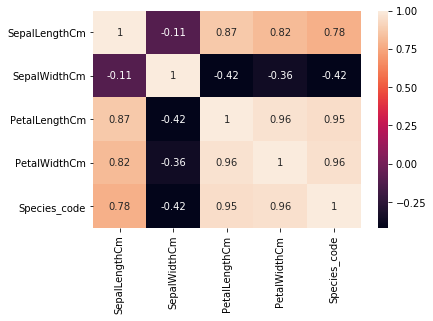

In [17]:
data.Species = pd.Categorical(data.Species)
data['Species_code'] = data.Species.cat.codes
f = (
    data.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species_code']]
).corr()

sns.heatmap(f, annot=True)

## Imputation for Partial Dependence

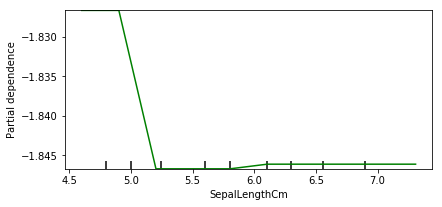

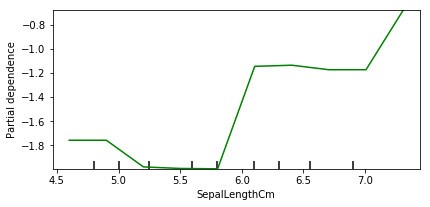

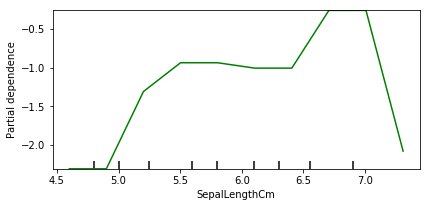

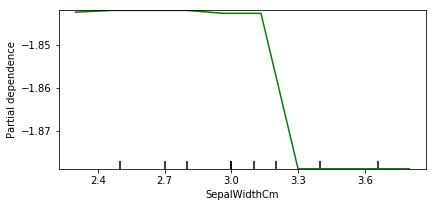

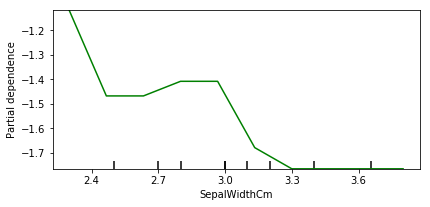

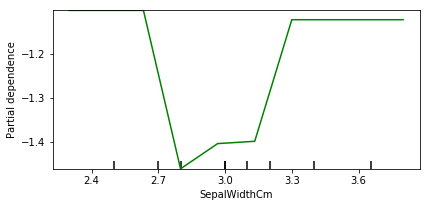

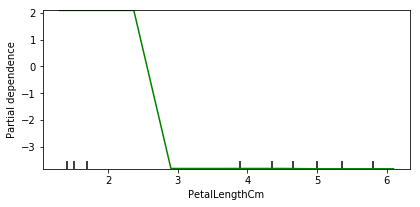

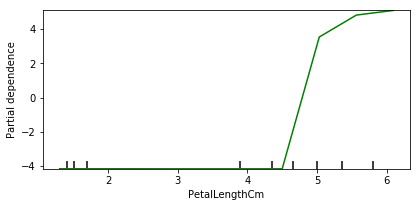

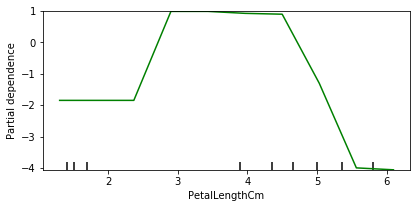

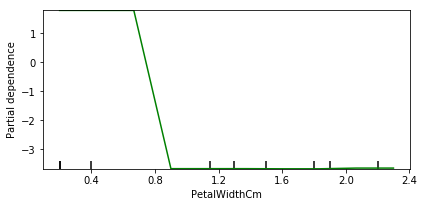

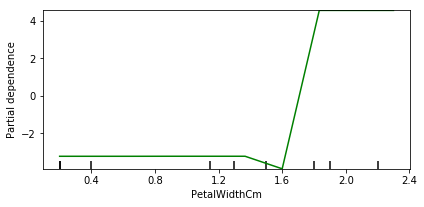

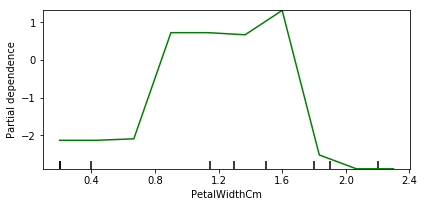

In [7]:
imputed_X_plus = X.copy()
cols_with_missing = (col for col in X.columns if X[col].isnull().any())
for col in cols_with_missing:
    print(col + 'was missing a value')
    imputed_X_plus[col + '_was_missing'] = imputed_X_plus[col].isnull()
my_imputer = SimpleImputer()
imputed_X_plus = my_imputer.fit_transform(imputed_X_plus)
cols = X.columns
my_model = GradientBoostingClassifier()
my_model.fit(imputed_X_plus, y)
for _ in range(len(cols)):
    my_plots = plot_partial_dependence(my_model, features = [_], X = imputed_X_plus, feature_names = cols,
                                       grid_resolution = 10, label = ['Iris-setosa'])
    my_plots = plot_partial_dependence(my_model, features = [_], X = imputed_X_plus, feature_names = cols,
                                       grid_resolution = 10, label = ['Iris-virginica'])
    my_plots = plot_partial_dependence(my_model, features = [_], X = imputed_X_plus, feature_names = cols,
                                       grid_resolution = 10, label = ['Iris-versicolor'])

## Encode string columns

In [8]:
le = LabelEncoder()
le.fit(data.Species)
y = le.transform(data.Species)

## Drop Irrelevant columns and make data model-ready

In [9]:
# Drop irrelevant columns
# Split data into training and testing data
pass # Because we are using cross-validation for this small dataset

## Defining custom scoring strategy

In [10]:
def iris_accuracy(y_true, y_pred):
    count = 0
    for _ in range(len(y_pred)):
        if y_true[_] == y_pred[_]:
            count += 1
    return count/len(y_pred)
score = make_scorer(iris_accuracy, greater_is_better = True)

### Linear Discriminant Analysis

In [11]:
def lda(X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), LinearDiscriminantAnalysis()), X, y, scoring = score,
                               cv = 5))

### Quadratic Discriminant Analysis

In [12]:
def qda(X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), QuadraticDiscriminantAnalysis()), X, y, scoring = score,
                                cv = 5))

### Ada Boost Classifier

In [13]:
def abc(ne, lr, X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), AdaBoostClassifier(n_estimators = ne, learning_rate = lr)),
                                X, y, scoring = score, cv = 5))

### Gradient Boosting Classifier

In [14]:
def gbc(ne, lr, X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(),
                                              GradientBoostingClassifier(n_estimators = ne, learning_rate = lr)), X, y,
                                scoring = score, cv = 5))

### Random Forest Classifier

In [15]:
def rfc(ne, md, X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(),
                                              GradientBoostingClassifier(n_estimators = ne, max_depth = md)), X, y,
                                scoring = score, cv = 5))

### Voting Classifier

In [36]:
def vc(e, X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), VotingClassifier(estimators = e)), X, y, scoring = score,
                                cv = 5))

### Gaussian Process Classifier

In [17]:
def gpc(X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), GaussianProcessClassifier(1.0 * RBF(1.0))), X, y,
                                scoring = score, cv = 5))

### Naive Bayes

In [18]:
def nb(X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), GaussianNB()), X, y, scoring = score, cv = 5))

### k Nearest Neighbors

In [19]:
def knn(nn, X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), KNeighborsClassifier(n_neighbors = nn)), X, y,
                                scoring = score, cv = 5))

### MLP Classifier

In [20]:
def mlp(X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), MLPClassifier()), X, y, scoring = score, cv = 5))

### SVC

In [21]:
def svc(X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), SVC(kernel = "linear", C = 0.025)), X, y,
                                scoring = score, cv = 5))

### Decision Tree Classifier

In [22]:
def dtc(md, X, y):
    return mean(cross_val_score(make_pipeline(SimpleImputer(), DecisionTreeClassifier(max_depth = md)), X, y,
                                scoring = score, cv = 5))


## Running the models

### Linear Discriminant Analysis

In [23]:
lda(X, y)

0.98

### Quadratic Discriminant Analysis

In [24]:
qda(X, y)

0.98

### Ada Boost Classifier

In [25]:
ne = [50, 100, 500, 1000]
lr = [0.02, 0.04, 0.06, 0.08, 0.1]
max_ne, max_lr, max_acc = 0, 0, 0.97
for _ in ne:
    for __ in lr:
        acc = abc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_lr = __
        print("(ne = " + str(_) + ", lr = " + str(__) + "): " + str(acc))
print(max_ne, max_lr, max_acc)

(ne = 50, lr = 0.02): 0.9400000000000001
(ne = 50, lr = 0.04): 0.9400000000000001
(ne = 50, lr = 0.06): 0.9400000000000001
(ne = 50, lr = 0.08): 0.9400000000000001
(ne = 50, lr = 0.1): 0.9400000000000001
(ne = 100, lr = 0.02): 0.9400000000000001
(ne = 100, lr = 0.04): 0.9400000000000001
(ne = 100, lr = 0.06): 0.9466666666666667
(ne = 100, lr = 0.08): 0.9400000000000001
(ne = 100, lr = 0.1): 0.9400000000000001
(ne = 500, lr = 0.02): 0.9400000000000001
(ne = 500, lr = 0.04): 0.9466666666666667
(ne = 500, lr = 0.06): 0.9466666666666667
(ne = 500, lr = 0.08): 0.9533333333333334
(ne = 500, lr = 0.1): 0.9533333333333334
(ne = 1000, lr = 0.02): 0.9466666666666667
(ne = 1000, lr = 0.04): 0.9466666666666667
(ne = 1000, lr = 0.06): 0.9466666666666667
(ne = 1000, lr = 0.08): 0.9533333333333334
(ne = 1000, lr = 0.1): 0.9533333333333334
0 0 97


### Gradient Boosting Classifier

In [27]:
ne = [5, 10, 50, 100, 500]
lr = [0.02, 0.04, 0.06, 0.08, 0.1]
max_ne, max_lr, max_acc = 0, 0, 0
for _ in ne:
    for __ in lr:
        acc = gbc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_lr = __
        print("(ne = " + str(_) + ", lr = " + str(__) + "): " + str(acc))
print(max_ne, max_lr, max_acc)

(ne = 5, lr = 0.02): 0.96
(ne = 5, lr = 0.04): 0.96
(ne = 5, lr = 0.06): 0.96
(ne = 5, lr = 0.08): 0.96
(ne = 5, lr = 0.1): 0.96
(ne = 10, lr = 0.02): 0.96
(ne = 10, lr = 0.04): 0.9666666666666667
(ne = 10, lr = 0.06): 0.96
(ne = 10, lr = 0.08): 0.96
(ne = 10, lr = 0.1): 0.96
(ne = 50, lr = 0.02): 0.96
(ne = 50, lr = 0.04): 0.96
(ne = 50, lr = 0.06): 0.96
(ne = 50, lr = 0.08): 0.96
(ne = 50, lr = 0.1): 0.9533333333333334
(ne = 100, lr = 0.02): 0.96
(ne = 100, lr = 0.04): 0.96
(ne = 100, lr = 0.06): 0.96
(ne = 100, lr = 0.08): 0.96
(ne = 100, lr = 0.1): 0.9533333333333334
(ne = 500, lr = 0.02): 0.9533333333333334
(ne = 500, lr = 0.04): 0.96
(ne = 500, lr = 0.06): 0.96
(ne = 500, lr = 0.08): 0.96
(ne = 500, lr = 0.1): 0.9533333333333334
10 0.04 0.9666666666666667


In [28]:
ne = [6, 10, 20, 35, 49]
lr = [0.02, 0.04, 0.06, 0.08, 0.1]
max_ne, max_lr, max_acc = 0, 0, 0
for _ in ne:
    for __ in lr:
        acc = gbc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_lr = __
        print("(ne = " + str(_) + ", lr = " + str(__) + "): " + str(acc))
print(max_ne, max_lr, max_acc)

(ne = 6, lr = 0.02): 0.9666666666666667
(ne = 6, lr = 0.04): 0.96
(ne = 6, lr = 0.06): 0.96
(ne = 6, lr = 0.08): 0.9533333333333334
(ne = 6, lr = 0.1): 0.9533333333333334
(ne = 10, lr = 0.02): 0.96
(ne = 10, lr = 0.04): 0.96
(ne = 10, lr = 0.06): 0.96
(ne = 10, lr = 0.08): 0.9533333333333334
(ne = 10, lr = 0.1): 0.96
(ne = 20, lr = 0.02): 0.96
(ne = 20, lr = 0.04): 0.96
(ne = 20, lr = 0.06): 0.96
(ne = 20, lr = 0.08): 0.96
(ne = 20, lr = 0.1): 0.96
(ne = 35, lr = 0.02): 0.96
(ne = 35, lr = 0.04): 0.96
(ne = 35, lr = 0.06): 0.96
(ne = 35, lr = 0.08): 0.96
(ne = 35, lr = 0.1): 0.96
(ne = 49, lr = 0.02): 0.96
(ne = 49, lr = 0.04): 0.96
(ne = 49, lr = 0.06): 0.96
(ne = 49, lr = 0.08): 0.96
(ne = 49, lr = 0.1): 0.96
6 0.02 0.9666666666666667


### Random Forest Classifier

In [30]:
ne = [5, 10, 50, 100]
md = [5, 50, 100, 500, 1000]
max_ne, max_md, max_acc = 0, 0, 0
for _ in ne:
    for __ in md:
        acc = gbc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_md = __
        print("(ne = " + str(_) + ", md = " + str(__) + "): " + str(acc))
print(max_ne, max_md, max_acc)

(ne = 5, md = 5): 0.96
(ne = 5, md = 50): 0.9333333333333333
(ne = 5, md = 100): 0.9466666666666667
(ne = 5, md = 500): 0.9533333333333334
(ne = 5, md = 1000): 0.96
(ne = 10, md = 5): 0.9466666666666667
(ne = 10, md = 50): 0.9333333333333333
(ne = 10, md = 100): 0.9266666666666666
(ne = 10, md = 500): 0.9466666666666667
(ne = 10, md = 1000): 0.9666666666666667
(ne = 50, md = 5): 0.96
(ne = 50, md = 50): 0.9333333333333333
(ne = 50, md = 100): 0.9466666666666667
(ne = 50, md = 500): 0.9533333333333334
(ne = 50, md = 1000): 0.9666666666666667
(ne = 100, md = 5): 0.9533333333333334
(ne = 100, md = 50): 0.9333333333333333
(ne = 100, md = 100): 0.9400000000000001
(ne = 100, md = 500): 0.9466666666666667
(ne = 100, md = 1000): 0.9666666666666667
10 1000 0.9666666666666667


In [31]:
ne = [5, 10, 20, 35, 50]
md = [500, 1000, 2000, 5000]
max_ne, max_md, max_acc = 0, 0, 0
for _ in ne:
    for __ in md:
        acc = gbc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_md = __
        print("(ne = " + str(_) + ", md = " + str(__) + "): " + str(acc))
print(max_ne, max_md, max_acc)

(ne = 5, md = 500): 0.9533333333333334
(ne = 5, md = 1000): 0.9666666666666667
(ne = 5, md = 2000): 0.9666666666666667
(ne = 5, md = 5000): 0.9666666666666667
(ne = 10, md = 500): 0.9533333333333334
(ne = 10, md = 1000): 0.9666666666666667
(ne = 10, md = 2000): 0.96
(ne = 10, md = 5000): 0.96
(ne = 20, md = 500): 0.9533333333333334
(ne = 20, md = 1000): 0.96
(ne = 20, md = 2000): 0.96
(ne = 20, md = 5000): 0.96
(ne = 35, md = 500): 0.9466666666666667
(ne = 35, md = 1000): 0.9666666666666667
(ne = 35, md = 2000): 0.9666666666666667
(ne = 35, md = 5000): 0.96
(ne = 50, md = 500): 0.9466666666666667
(ne = 50, md = 1000): 0.9666666666666667
(ne = 50, md = 2000): 0.9666666666666667
(ne = 50, md = 5000): 0.9666666666666667
5 1000 0.9666666666666667


In [32]:
ne = [1, 2, 5, 8, 10]
md = [600, 1000, 1500]
max_ne, max_md, max_acc = 0, 0, 0
for _ in ne:
    for __ in md:
        acc = gbc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_md = __
        print("(ne = " + str(_) + ", md = " + str(__) + "): " + str(acc))
print(max_ne, max_md, max_acc)

(ne = 1, md = 600): 0.96
(ne = 1, md = 1000): 0.9666666666666667
(ne = 1, md = 1500): 0.96
(ne = 2, md = 600): 0.96
(ne = 2, md = 1000): 0.96
(ne = 2, md = 1500): 0.96
(ne = 5, md = 600): 0.9666666666666667
(ne = 5, md = 1000): 0.9666666666666667
(ne = 5, md = 1500): 0.96
(ne = 8, md = 600): 0.9666666666666667
(ne = 8, md = 1000): 0.9666666666666667
(ne = 8, md = 1500): 0.9666666666666667
(ne = 10, md = 600): 0.9666666666666667
(ne = 10, md = 1000): 0.96
(ne = 10, md = 1500): 0.9666666666666667
1 1000 0.9666666666666667


In [34]:
ne = [1, 2, 5]
md = [1000, 5000, 10000, 100000]
max_ne, max_md, max_acc = 0, 0, 0
for _ in ne:
    for __ in md:
        acc = gbc(_, __, X, y)
        if acc > max_acc:
            max_acc = acc
            max_ne = _
            max_md = __
        print("(ne = " + str(_) + ", md = " + str(__) + "): " + str(acc))
print(max_ne, max_md, max_acc)

(ne = 1, md = 1000): 0.9666666666666667
(ne = 1, md = 5000): 0.96
(ne = 1, md = 10000): 0.96
(ne = 1, md = 100000): 0.96
(ne = 2, md = 1000): 0.9666666666666667
(ne = 2, md = 5000): 0.9666666666666667
(ne = 2, md = 10000): 0.9666666666666667
(ne = 2, md = 100000): 0.9666666666666667
(ne = 5, md = 1000): 0.96
(ne = 5, md = 5000): 0.96
(ne = 5, md = 10000): 0.9666666666666667
(ne = 5, md = 100000): 0.96
1 1000 0.9666666666666667


### Voting Classifier

In [39]:
e = [5, 10, 100, 500, 1000]
max_e, max_acc = 0, 0
for _ in e:
    acc = vc(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_e = _
    print("(e = " + str(_) + "): " + str(acc))
print(max_e, max_acc)

C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


TypeError: object of type 'int' has no len()

### Gaussian Process Classifier

In [40]:
gpc(X, y)

C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.13932806, -0.07261931]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


0.9666666666666667

### Naive Bayes

In [41]:
nb(X, y)

0.9533333333333334

### k Nearest Neighbors

In [46]:
nn = [2, 5, 10, 15, 20, 50]
max_nn, max_acc = 0, 0
for _ in nn:
    acc = knn(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_nn = _
    print("(nn = " + str(_) + "): " + str(acc))
print(max_nn, max_acc)

(nn = 2): 0.9466666666666667
(nn = 5): 0.9733333333333334
(nn = 10): 0.98
(nn = 15): 0.9666666666666667
(nn = 20): 0.96
(nn = 50): 0.9133333333333333
10 0.98


In [47]:
nn = [6, 8, 10, 12, 14]
max_nn, max_acc = 0, 0
for _ in nn:
    acc = knn(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_nn = _
    print("(nn = " + str(_) + "): " + str(acc))
print(max_nn, max_acc)

(nn = 6): 0.98
(nn = 8): 0.9666666666666667
(nn = 10): 0.98
(nn = 12): 0.98
(nn = 14): 0.9666666666666667
6 0.98


In [48]:
nn = [5, 6, 7]
max_nn, max_acc = 0, 0
for _ in nn:
    acc = knn(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_nn = _
    print("(nn = " + str(_) + "): " + str(acc))
print(max_nn, max_acc)

(nn = 5): 0.9733333333333334
(nn = 6): 0.98
(nn = 7): 0.98
6 0.98


### MLP Classifier

In [49]:
mlp(X, y)

C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

0.98

### SVC

In [50]:
svc(X, y)

0.9466666666666667

### Decision Tree Classifier

In [54]:
md = [2, 5, 10, 15, 20, 50]
max_md, max_acc = 0, 0
for _ in md:
    acc = dtc(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_md = _
    print("(md = " + str(_) + "): " + str(acc))
print(max_md, max_acc)

(md = 2): 0.9333333333333333
(md = 5): 0.9533333333333334
(md = 10): 0.96
(md = 15): 0.9666666666666667
(md = 20): 0.9666666666666667
(md = 50): 0.96
15 0.9666666666666667


In [55]:
md = [12, 14, 15, 16, 18]
max_md, max_acc = 0, 0
for _ in md:
    acc = dtc(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_md = _
    print("(md = " + str(_) + "): " + str(acc))
print(max_md, max_acc)

(md = 12): 0.9666666666666667
(md = 14): 0.9666666666666667
(md = 15): 0.9666666666666667
(md = 16): 0.96
(md = 18): 0.96
12 0.9666666666666667


In [56]:
md = [11, 12, 13]
max_md, max_acc = 0, 0
for _ in md:
    acc = dtc(_, X, y)
    if acc > max_acc:
        max_acc = acc
        max_md = _
    print("(md = " + str(_) + "): " + str(acc))
print(max_md, max_acc)

(md = 11): 0.9666666666666667
(md = 12): 0.96
(md = 13): 0.9666666666666667
11 0.9666666666666667
